# eml to DuckDB

Notebook to explore cleanly how to go from eml file format to DuckDB database followed The Classes in models/models.py cleanly without different codes etc.
This has to be transformed into different function files later on.

## Imports

In [1]:
from __future__ import annotations
import mailbox
import pandas as pd
import os
import email
from email.header import decode_header
import datetime
from bs4 import BeautifulSoup
from tqdm import tqdm

import duckdb

import json
import uuid
from typing import Dict, Any, Optional, Union

from pathlib import Path

from email import policy


import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display

# from eralchemy2 import render_er
# from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float

import jinja2


### Importing Function & Classes

#### Classes

In [2]:
from src.data.email_analyzer import EmailAnalyzer

#### Functions

In [3]:
from src.data.duckdb_utils import setup_database

from src.data.eml_transformation import extract_message_data


# from src.data.eml_transformation import (
#     extract_message_data,
#     extract_email_data,
#     extract_email_body,
#     extract_email_attachments,
#     extract_email_headers,
#     extract_email_metadata,
#     extract_email_references,
#     extract_email_subject,
#     extract_email_to_from_cc_bcc,
#     extract_email_date,
# )

### Vars

In [4]:
### Test des fonctions:
# mbox_single_file_path = 'data/processed/mailbox_cecile/AG.mbox'
# mbox_path = 'data/processed/mailbox_cecile/'
# TEST_SAMPLE_PATH = 'data/processed/celine_readpst_with_S/celine.guyon/Archive/'
TEST_SAMPLE_PATH = 'data/processed/celine_readpst_with_S/'
db_path = "data/Projects/celine.duckdb"

## Functions

### Main

In [5]:

def process_eml_to_duckdb(directory: Union[str, Path],
                          conn: 'duckdb.DuckDBPyConnection',
                          batch_size: int = 100,
                          entity_cache: Optional[Dict[str, str]] = None) -> Dict[str, str]:
    """
    Recursively process all .eml files in a directory and its subdirectories directly to DuckDB in batches

    Args:
        directory: Root directory to search for .eml files
        conn: DuckDB connection
        batch_size: Number of records to process before committing to the database
        entity_cache: Cache to store entities we've already seen

    Returns:
        Updated entity cache after processing
    """
    if entity_cache is None:
        entity_cache = {}  # Cache to store entities we've already seen

    directory = Path(directory)  # Convert to Path object if it's a string

    # Find all .eml files recursively
    eml_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.eml'):
                eml_files.append(Path(root) / file)

    print(f"Found {len(eml_files)} .eml files to process")

    # Process in batches for each table
    entity_batch = []
    entity_alias_emails_batch = []
    mailing_list_batch = []
    sender_email_batch = []
    receiver_email_batch = []
    to_recipients_batch = []
    cc_recipients_batch = []
    bcc_recipients_batch = []
    attachments_batch = []

    # Process each .eml file
    for i, eml_path in enumerate(tqdm(eml_files, desc="Processing emails")):
        # Determine folder structure relative to the root directory
        rel_path = eml_path.relative_to(directory)
        folder_name = str(rel_path.parent) if rel_path.parent != Path('.') else 'root'

        try:
            # Parse the email file
            with open(eml_path, 'rb') as f:
                message = email.message_from_binary_file(f, policy=policy.default)

            email_data, receiver_email = extract_message_data(message, folder_name)

            # Process sender entity
            sender = receiver_email.sender
            if sender.email.email not in entity_cache:
                entity_id = str(uuid.uuid4())
                entity_cache[sender.email.email] = entity_id

                # Add to entities batch
                entity_batch.append({
                    'id': entity_id,
                    'name': sender.name,
                    'email': sender.email.email,
                    'alias_names': json.dumps(sender.alias_names) if sender.alias_names else None,
                    'is_physical_person': sender.is_physical_person
                })

                # Process alias emails if any
                if sender.alias_emails:
                    for alias_email in sender.alias_emails:
                        entity_alias_emails_batch.append({
                            'id': str(uuid.uuid4()),
                            'entity_id': entity_id,
                            'email': alias_email.email
                        })
            else:
                # Get cached entity ID
                entity_id = entity_cache[sender.email.email]

            # Process sender email
            sender_email = receiver_email.sender_email
            sender_email_batch.append({
                'id': sender_email.id,
                'sender_id': entity_id,  # Use cached or new entity ID
                'body': sender_email.body,
                'timestamp': sender_email.timestamp
            })

            # Process receiver email
            reply_to_id = None
            if receiver_email.reply_to:
                reply_to_email = receiver_email.reply_to.email.email
                if reply_to_email not in entity_cache:
                    reply_to_id = str(uuid.uuid4())
                    entity_cache[reply_to_email] = reply_to_id

                    entity_batch.append({
                        'id': reply_to_id,
                        'name': receiver_email.reply_to.name,
                        'email': reply_to_email,
                        'alias_names': None,
                        'is_physical_person': True
                    })
                else:
                    reply_to_id = entity_cache[reply_to_email]

            # Add mailing list if present
            mailing_list_id = None
            if receiver_email.mailing_list:
                mailing_list_id = receiver_email.mailing_list.id
                mailing_list_batch.append({
                    'id': mailing_list_id,
                    'name': receiver_email.mailing_list.name,
                    'description': receiver_email.mailing_list.description,
                    'email_address': receiver_email.mailing_list.email_address.email
                })

            # Add receiver email
            receiver_email_batch.append({
                'id': receiver_email.id,
                'sender_email_id': sender_email.id,
                'sender_id': entity_id,
                'reply_to_id': reply_to_id,
                'timestamp': receiver_email.timestamp,
                'subject': receiver_email.subject,
                'body': receiver_email.body,
                'is_deleted': receiver_email.is_deleted,
                'folder': folder_name,  # Using the relative folder path as folder name
                'is_spam': receiver_email.is_spam,
                'mailing_list_id': mailing_list_id,
                'importance_score': receiver_email.importance_score,
                'mother_email_id': None,  # Will be updated later
                'message_id': email_data.get('message_id'),
                'references': email_data.get('references'),
                'in_reply_to': email_data.get('in_reply_to')
            })

            # Process recipients (to, cc, bcc)
            if receiver_email.to:
                for entity in receiver_email.to:
                    if entity.email.email not in entity_cache:
                        to_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = to_entity_id

                        entity_batch.append({
                            'id': to_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })

                        # Process alias emails
                        if entity.alias_emails:
                            for alias_email in entity.alias_emails:
                                entity_alias_emails_batch.append({
                                    'id': str(uuid.uuid4()),
                                    'entity_id': to_entity_id,
                                    'email': alias_email.email
                                })
                    else:
                        to_entity_id = entity_cache[entity.email.email]

                    # Add to recipients relationship
                    to_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': to_entity_id
                    })

            # Process CC recipients
            if receiver_email.cc:
                for entity in receiver_email.cc:
                    if entity.email.email not in entity_cache:
                        cc_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = cc_entity_id

                        entity_batch.append({
                            'id': cc_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })
                    else:
                        cc_entity_id = entity_cache[entity.email.email]

                    # Add cc recipients relationship
                    cc_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': cc_entity_id
                    })

            # Process BCC recipients
            if receiver_email.bcc:
                for entity in receiver_email.bcc:
                    if entity.email.email not in entity_cache:
                        bcc_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = bcc_entity_id

                        entity_batch.append({
                            'id': bcc_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })
                    else:
                        bcc_entity_id = entity_cache[entity.email.email]

                    # Add bcc recipients relationship
                    bcc_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': bcc_entity_id
                    })

            # Process attachments
            if receiver_email.attachments:
                for attachment in receiver_email.attachments:
                    content_type = getattr(attachment, 'content_type', 'application/octet-stream')
                    size = getattr(attachment, 'size', len(attachment.content) if attachment.content else 0)

                    attachments_batch.append({
                        'id': str(uuid.uuid4()),
                        'email_id': receiver_email.id,
                        'filename': attachment.filename,
                        'content': attachment.content,
                        'content_type': content_type,
                        'size': size
                    })
        except Exception as e:
            print(f"Error processing email {eml_path}: {e}")
            continue

        # Process batch when it reaches the batch size or on the last file
        if len(receiver_email_batch) >= batch_size or i == len(eml_files) - 1:
            try:
                # Insert entities
                if entity_batch:
                    entities_df = pd.DataFrame(entity_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO entities
                    SELECT * FROM entities_df
                    """)
                    entity_batch = []

                # Insert entity alias emails
                if entity_alias_emails_batch:
                    alias_emails_df = pd.DataFrame(entity_alias_emails_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO entity_alias_emails
                    SELECT * FROM alias_emails_df
                    """)
                    entity_alias_emails_batch = []

                # Insert mailing lists
                if mailing_list_batch:
                    mailing_lists_df = pd.DataFrame(mailing_list_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO mailing_lists
                    SELECT * FROM mailing_lists_df
                    """)
                    mailing_list_batch = []

                # Insert sender emails
                if sender_email_batch:
                    sender_emails_df = pd.DataFrame(sender_email_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO sender_emails
                    SELECT * FROM sender_emails_df
                    """)
                    sender_email_batch = []

                # Insert receiver emails
                if receiver_email_batch:
                    receiver_emails_df = pd.DataFrame(receiver_email_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO receiver_emails
                    SELECT * FROM receiver_emails_df
                    """)
                    receiver_email_batch = []

                # Insert recipient relationships
                if to_recipients_batch:
                    to_recipients_df = pd.DataFrame(to_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_to
                    SELECT * FROM to_recipients_df
                    """)
                    to_recipients_batch = []

                if cc_recipients_batch:
                    cc_recipients_df = pd.DataFrame(cc_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_cc
                    SELECT * FROM cc_recipients_df
                    """)
                    cc_recipients_batch = []

                if bcc_recipients_batch:
                    bcc_recipients_df = pd.DataFrame(bcc_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_bcc
                    SELECT * FROM bcc_recipients_df
                    """)
                    bcc_recipients_batch = []

                # Insert attachments
                if attachments_batch:
                    attachments_df = pd.DataFrame(attachments_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO attachments
                    SELECT * FROM attachments_df
                    """)
                    attachments_batch = []

                # Commit to save progress
                conn.commit()
            except Exception as e:
                print(f"Error inserting batch into database: {e}")
                # Continue processing even if one batch fails
                entity_batch = []
                entity_alias_emails_batch = []
                mailing_list_batch = []
                sender_email_batch = []
                receiver_email_batch = []
                to_recipients_batch = []
                cc_recipients_batch = []
                bcc_recipients_batch = []
                attachments_batch = []

    print(f"Completed processing {len(eml_files)} .eml files")

    return entity_cache

In [6]:


def process_eml_files(directory: Union[str, Path],
                     output_path: Optional[str] = None) -> None:
    """
    Recursively process .eml files from a directory and its subdirectories and save to DuckDB format
    with normalized tables

    Args:
        directory: Directory containing .eml files (may be nested in subdirectories)
        output_path: Output file path (default: emails.duckdb)
    """
    # Set default output path if not provided
    if output_path is None:
        output_path = 'emails.duckdb'
    elif not output_path.endswith('.duckdb'):
        output_path = f"{output_path}.duckdb"

    # Setup database
    conn = setup_database(output_path)

    # Convert directory to Path if it's a string
    directory = Path(directory)

    # Entity cache to avoid duplicates across files
    entity_cache = {}

    try:
        # Process all .eml files in the directory and subdirectories
        print(f"Processing .eml files in {directory} and subdirectories...")
        entity_cache = process_eml_to_duckdb(directory, conn, entity_cache=entity_cache)
    except Exception as e:
        print(f"Error processing directory {directory}: {e}")

    try:
        # Create relationships between emails (mother/child relationships)
        print("Creating email thread relationships...")
        conn.execute("""
        UPDATE receiver_emails
        SET mother_email_id = (
            SELECT r2.id
            FROM receiver_emails r2
            WHERE r2.message_id = receiver_emails.in_reply_to
            LIMIT 1
        )
        WHERE in_reply_to IS NOT NULL
        """)

        # Populate the children relationships table
        print("Populating child email relationships...")
        conn.execute("""
        INSERT INTO email_children (parent_id, child_id)
        SELECT mother_email_id, id
        FROM receiver_emails
        WHERE mother_email_id IS NOT NULL
        AND mother_email_id IN (SELECT id FROM receiver_emails)
        AND id != mother_email_id  -- Prevent self-references
        """)
    except Exception as e:
        print(f"Warning: Error in relationship creation: {e}")
        print("Continuing with database optimization...")

    # Final optimization and cleanup
    print("Optimizing database...")


    conn.execute("PRAGMA enable_optimizer") # conn.execute("PRAGMA optimize_database")
    conn.close()

    print(f"DuckDB database saved to {output_path}")
    print("""
Database structure:
- entities: Stores all senders and recipients
- entity_alias_emails: Stores alias emails for entities
- sender_emails: Stores email data from senders
- receiver_emails: Stores received email data
- email_recipients_to/cc/bcc: Links emails to recipient entities
- attachments: Stores email attachments
- email_children: Stores parent-child relationships between emails
- mailing_lists: Stores mailing list information
- organizations: Stores organization information
- positions: Stores position information
- entity_positions: Links entities to positions
""")

In [7]:
duckdb_conn = setup_database(db_path)

attempting connection
Connection Done


In [8]:
# setup_database(db_path)
# duckdb_conn = duckdb.connect(db_path)
# process_mbox_to_duckdb(mbox_single_file_path, duckdb_conn)

# Make The Database here (desactivated while db is up)

In [9]:
# process_eml_files(TEST_SAMPLE_PATH, db_path)
# mbox_path

In [10]:
pd.reset_option('display.max_columns')

analyzer =EmailAnalyzer(db_path)
analyzer.get_email_summary()

df_db_cleaned = analyzer.export_to_dataframe()
df_db_cleaned

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,message_id,subject,from,to,date,folder,attachment_count,body
0,<CE817F92-BE3D-42A0-A833-A08C3B1E7C4A@free.fr>,Communiqué,Agnès Vatican,celine.guyon@archivistes.org,2020-10-18 12:18:49,root,0,"Bonjour Céline, l’AAF a-t-elle prévu de faire ..."
1,<01ea01d700bc$2453c3c0$6cfb4b40$@archivistes.q...,RE: Table-ronde Congrès AAQ 2021 : Archives de...,Louis Germain,celine.guyon@archivistes.org,2021-02-11 22:23:29,root,1,"<meta http-equiv=""Content-Type"" content=""text/..."
2,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,Table-ronde Congrès AAQ 2021 : Archives de la ...,Louis Germain,"mldubois@valorescence.be, taik.bourhis@umontre...",2021-02-02 17:23:16,root,2,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
3,<cf77b68bfb2844369ec522a5aac4205a@archivistes....,RE: Facture MIC - facilitation Groupe de trava...,"AAF - Anne Clerc, déléguée générale","Vincent Taillandier - Les MIC, 'Myriam FAVREAU'",2020-12-01 13:23:54,root,4,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
4,<0806fb4275064af9ab8141693efd9205@archivistes....,RE: Facture MIC - facilitation Groupe de trava...,"AAF - Anne Clerc, déléguée générale",'Myriam FAVREAU',2020-12-01 11:46:05,root,6,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
...,...,...,...,...,...,...,...,...
19152,<43a7e76b65cd4762adad4f298464d573@archivistes....,Rejoindre la conférence de presse de ce jeudi ...,"AAF - Anne Clerc, déléguée générale",None,2020-10-01 15:29:51,celine.guyon/Boîte de réception,5,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
19153,<28923e0651ea49b38f674238e0673a48@archivistes....,RE: covid - auto confinement,"AAF - Anne Clerc, déléguée générale",None,2020-09-04 14:34:55,celine.guyon/Boîte de réception,0,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
19154,<d5df3559fce24873b24f1fd15103eed6@archivistes....,"Rejoindre le webinaire ""déconfinement et de la...","AAF - Anne Clerc, déléguée générale",None,2020-06-02 12:24:47,celine.guyon/Boîte de réception,6,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."
19155,<0af88354990c4543822c748fd58b28a1@archivistes....,"Rejoindre le webinaire ""La collecte au temps d...","AAF - Anne Clerc, déléguée générale",None,2020-05-04 10:25:59,celine.guyon/Boîte de réception,8,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ..."


In [11]:
# Method 1: List all tables
# tables = duckdb_conn.execute("SELECT * FROM information_schema.tables").fetchall()
# print("Tables in database:")
# for table in tables:
#     print(table)

# Method 2: Get all tables and their columns
all_columns = duckdb_conn.execute("""
    SELECT
        table_schema,
        table_name,
        column_name,
        data_type
    FROM information_schema.columns
    ORDER BY table_schema, table_name, ordinal_position
""").fetchall()
print("\nAll columns in database:")
for column in all_columns:
    print(column)


# duckdb_conn


All columns in database:
('main', 'attachments', 'id', 'VARCHAR')
('main', 'attachments', 'email_id', 'VARCHAR')
('main', 'attachments', 'filename', 'VARCHAR')
('main', 'attachments', 'content', 'BLOB')
('main', 'attachments', 'content_type', 'VARCHAR')
('main', 'attachments', 'size', 'INTEGER')
('main', 'email_children', 'parent_id', 'VARCHAR')
('main', 'email_children', 'child_id', 'VARCHAR')
('main', 'email_recipients_bcc', 'email_id', 'VARCHAR')
('main', 'email_recipients_bcc', 'entity_id', 'VARCHAR')
('main', 'email_recipients_cc', 'email_id', 'VARCHAR')
('main', 'email_recipients_cc', 'entity_id', 'VARCHAR')
('main', 'email_recipients_to', 'email_id', 'VARCHAR')
('main', 'email_recipients_to', 'entity_id', 'VARCHAR')
('main', 'embeddings', 'email_id', 'VARCHAR')
('main', 'embeddings', 'embedding_tiny', 'BLOB')
('main', 'entities', 'id', 'VARCHAR')
('main', 'entities', 'name', 'VARCHAR')
('main', 'entities', 'email', 'VARCHAR')
('main', 'entities', 'alias_names', 'JSON')
('main',

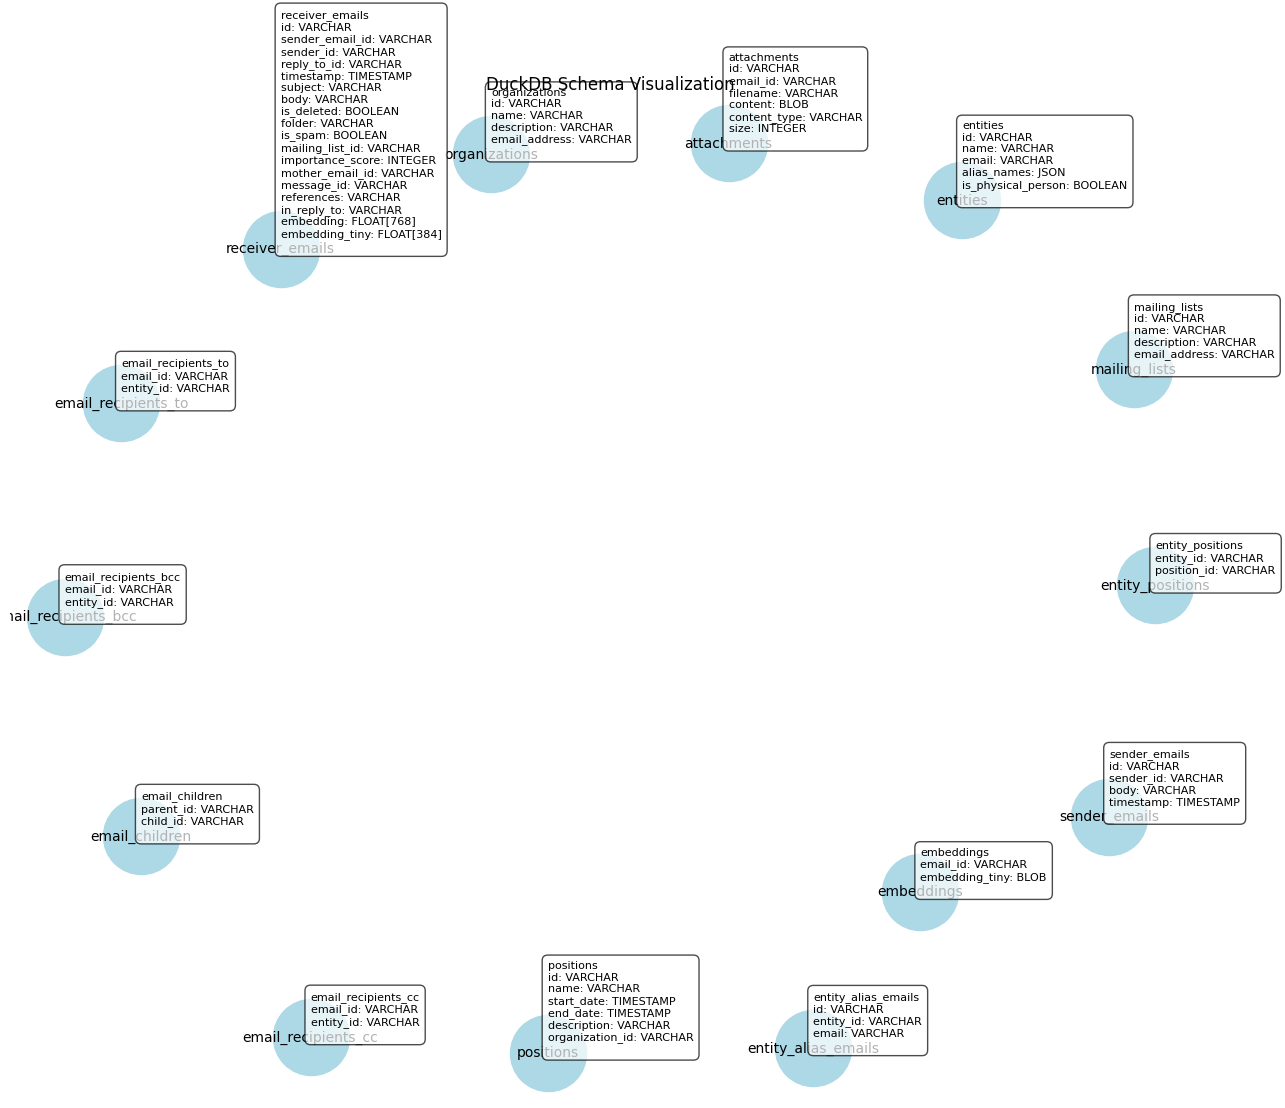

In [12]:
# Connect to your DuckDB database
# conn = duckdb.connect('your_database.db')  # or use ':memory:' for in-memory database

# Method 1: Get schema information as pandas DataFrame
def get_schema_as_dataframe():
    # Get all tables
    tables_df = duckdb_conn.execute("""
        SELECT table_schema, table_name
        FROM information_schema.tables
        WHERE table_schema != 'pg_catalog'
    """).df()

    # Get all columns with their data types
    columns_df = duckdb_conn.execute("""
        SELECT
            table_schema,
            table_name,
            column_name,
            data_type,
            is_nullable,
            column_default
        FROM information_schema.columns
        WHERE table_schema != 'pg_catalog'
        ORDER BY table_schema, table_name, ordinal_position
    """).df()

    return tables_df, columns_df

# Method 2: Print schema in a readable format
def print_schema():
    # Get all tables
    tables = duckdb_conn.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main'
    """).fetchall()

    for table in tables:
        table_name = table[0]
        print(f"\n=== TABLE: {table_name} ===")

        # Get columns for this table
        columns = duckdb_conn.execute(f"""
            DESCRIBE {table_name}
        """).fetchall()

        # Print column information
        for col in columns:
            print(f"{col[0]}: {col[1]}")

# Method 3: Visualize schema using networkx and matplotlib
def visualize_schema():
    # Get tables and their columns
    tables_columns = duckdb_conn.execute("""
        SELECT
            table_name,
            column_name,
            data_type
        FROM information_schema.columns
        WHERE table_schema = 'main'
        ORDER BY table_name, ordinal_position
    """).fetchall()

    # Create a graph
    G = nx.DiGraph()

    # Group by tables
    tables = {}
    for table_name, column_name, data_type in tables_columns:
        if table_name not in tables:
            tables[table_name] = []
        tables[table_name].append((column_name, data_type))

    # Add nodes for tables
    for table_name, columns in tables.items():
        # Create label with table name and columns
        label = f"{table_name}\n"
        for col_name, col_type in columns:
            label += f"{col_name}: {col_type}\n"

        G.add_node(table_name, label=label)

    # Try to find foreign key relationships (this is simplified)
    # In a real scenario, you'd need to query DuckDB's constraints
    for table1 in tables:
        for table2 in tables:
            if table1 != table2:
                for col1_name, _ in tables[table1]:
                    if col1_name == f"{table2}_id":
                        G.add_edge(table1, table2)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=3000, arrows=True, font_size=10)

    # Add detailed labels
    labels = nx.get_node_attributes(G, 'label')
    text_items = {}
    for node, label in labels.items():
        text_items[node] = plt.annotate(label, xy=pos[node],
                                       xytext=(0, 0),
                                       textcoords="offset points",
                                       bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7),
                                       fontsize=8)

    plt.title("DuckDB Schema Visualization")
    plt.show()

# Example usage:
tables_df, columns_df = get_schema_as_dataframe()
# display(tables_df)
# display(columns_df)

# print_schema()

visualize_schema()

In [13]:
print_schema()


=== TABLE: attachments ===
id: VARCHAR
email_id: VARCHAR
filename: VARCHAR
content: BLOB
content_type: VARCHAR
size: INTEGER

=== TABLE: email_children ===
parent_id: VARCHAR
child_id: VARCHAR

=== TABLE: email_recipients_bcc ===
email_id: VARCHAR
entity_id: VARCHAR

=== TABLE: email_recipients_cc ===
email_id: VARCHAR
entity_id: VARCHAR

=== TABLE: email_recipients_to ===
email_id: VARCHAR
entity_id: VARCHAR

=== TABLE: embeddings ===
email_id: VARCHAR
embedding_tiny: BLOB

=== TABLE: entities ===
id: VARCHAR
name: VARCHAR
email: VARCHAR
alias_names: JSON
is_physical_person: BOOLEAN

=== TABLE: entity_alias_emails ===
id: VARCHAR
entity_id: VARCHAR
email: VARCHAR

=== TABLE: entity_positions ===
entity_id: VARCHAR
position_id: VARCHAR

=== TABLE: mailing_lists ===
id: VARCHAR
name: VARCHAR
description: VARCHAR
email_address: VARCHAR

=== TABLE: organizations ===
id: VARCHAR
name: VARCHAR
description: VARCHAR
email_address: VARCHAR

=== TABLE: positions ===
id: VARCHAR
name: VARCHAR
s

In [14]:

# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

In [15]:
analyzer =EmailAnalyzer(db_path)

df_db_cleaned = analyzer.get_comprehensive_email_dataset()
df_db_cleaned.head(2)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,email_id,message_id,timestamp,subject,body,folder,is_deleted,is_spam,importance_score,in_reply_to,references,sender_id,sender_name,sender_email,sender_is_person,reply_to_id,reply_to_name,reply_to_email,to_recipients,to_emails,cc_recipients,cc_emails,bcc_recipients,bcc_emails,mailing_list_id,mailing_list_name,mailing_list_email,attachment_count,attachment_filenames,total_attachment_size,child_email_count,mother_email_id
0,f711645f-fa07-4637-9476-0eae7c71a305,<8aa028c40ef7146ed18990fc0c9e7a19@archivistes.be>,2021-02-12 12:33:13,Re: Table-ronde Congrès AAQ 2021 : Archives de...,"<html><head>\n<meta http-equiv=""Content-Type"" ...",root,False,False,0,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,a0980a7b-7510-47ca-a0d7-52661004692e,coordination@archivistes.be,coordination@archivistes.be,True,None,None,None,Louis Germain,louis.germain@archivistes.qc.ca,"mldubois@valorescence.be, taik.bourhis@umontre...","mldubois@valorescence.be, taik.bourhis@umontre...",None,None,None,None,None,4,Congres_AAQ_Licence_Table-ronde_LEssire_AAFB.p...,889289.0,0,None
1,17d50d33-c095-47b5-8903-420ca1acceb8,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,2021-02-02 17:23:16,Table-ronde Congrès AAQ 2021 : Archives de la ...,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ...",root,False,False,0,,,db5bc2b1-230e-45a4-9027-636675587644,Louis Germain,louis.germain@archivistes.qc.ca,True,None,None,None,"mldubois@valorescence.be, taik.bourhis@umontre...","mldubois@valorescence.be, taik.bourhis@umontre...",conseil@archivistes.qc.ca,conseil@archivistes.qc.ca,None,None,None,None,None,2,"Congres_AAQ_Licence_Table-ronde.pdf, image001.jpg",242366.0,0,None


In [16]:
df_db_cleaned.head(2)

,email_id,message_id,timestamp,subject,body,folder,is_deleted,is_spam,importance_score,in_reply_to,references,sender_id,sender_name,sender_email,sender_is_person,reply_to_id,reply_to_name,reply_to_email,to_recipients,to_emails,cc_recipients,cc_emails,bcc_recipients,bcc_emails,mailing_list_id,mailing_list_name,mailing_list_email,attachment_count,attachment_filenames,total_attachment_size,child_email_count,mother_email_id
0,f711645f-fa07-4637-9476-0eae7c71a305,<8aa028c40ef7146ed18990fc0c9e7a19@archivistes.be>,2021-02-12 12:33:13,Re: Table-ronde Congrès AAQ 2021 : Archives de...,"<html><head>\n<meta http-equiv=""Content-Type"" ...",root,False,False,0,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,a0980a7b-7510-47ca-a0d7-52661004692e,coordination@archivistes.be,coordination@archivistes.be,True,None,None,None,Louis Germain,louis.germain@archivistes.qc.ca,"mldubois@valorescence.be, taik.bourhis@umontre...","mldubois@valorescence.be, taik.bourhis@umontre...",None,None,None,None,None,4,Congres_AAQ_Licence_Table-ronde_LEssire_AAFB.p...,889289.0,0,None
1,17d50d33-c095-47b5-8903-420ca1acceb8,<014d01d6f97f$b6450df0$22cf29d0$@archivistes.q...,2021-02-02 17:23:16,Table-ronde Congrès AAQ 2021 : Archives de la ...,"<html xmlns:v=""urn:schemas-microsoft-com:vml"" ...",root,False,False,0,,,db5bc2b1-230e-45a4-9027-636675587644,Louis Germain,louis.germain@archivistes.qc.ca,True,None,None,None,"mldubois@valorescence.be, taik.bourhis@umontre...","mldubois@valorescence.be, taik.bourhis@umontre...",conseil@archivistes.qc.ca,conseil@archivistes.qc.ca,None,None,None,None,None,2,"Congres_AAQ_Licence_Table-ronde.pdf, image001.jpg",242366.0,0,None


In [17]:
# duckdb_conn.execute("ALTER TABLE receiver_emails DROP COLUMN IF EXISTS embedding;")
# duckdb_conn.execute("ALTER TABLE receiver_emails ADD COLUMN embedding FLOAT[384];")


duckdb_conn.execute("ALTER TABLE receiver_emails ADD COLUMN IF NOT EXISTS embedding_tiny FLOAT[384];")
# duckdb_conn.execute("ALTER TABLE receiver_emails ADD COLUMN embedding_tiny FLOAT[384];")


In [18]:

# Drop the embeddings table if it exists
duckdb_conn.execute("DROP TABLE IF EXISTS embeddings;")

In [19]:
duckdb_conn.execute("""
    CREATE TABLE IF NOT EXISTS embeddings (
        email_id VARCHAR PRIMARY KEY,  -- Changed to VARCHAR to match receiver_emails(id)
        embedding_tiny BLOB,
        FOREIGN KEY (email_id) REFERENCES receiver_emails(id)
    );
""")

In [20]:
# Describe the table to get the schema, which might show relationships
result = duckdb_conn.execute("DESCRIBE receiver_emails").fetchall()

# Print the schema result
print(result)


[('id', 'VARCHAR', 'NO', 'PRI', None, None), ('sender_email_id', 'VARCHAR', 'YES', None, None, None), ('sender_id', 'VARCHAR', 'YES', None, None, None), ('reply_to_id', 'VARCHAR', 'YES', None, None, None), ('timestamp', 'TIMESTAMP', 'YES', None, None, None), ('subject', 'VARCHAR', 'YES', None, None, None), ('body', 'VARCHAR', 'YES', None, None, None), ('is_deleted', 'BOOLEAN', 'YES', None, "CAST('f' AS BOOLEAN)", None), ('folder', 'VARCHAR', 'YES', None, "'inbox'", None), ('is_spam', 'BOOLEAN', 'YES', None, "CAST('f' AS BOOLEAN)", None), ('mailing_list_id', 'VARCHAR', 'YES', None, None, None), ('importance_score', 'INTEGER', 'YES', None, '0', None), ('mother_email_id', 'VARCHAR', 'YES', None, None, None), ('message_id', 'VARCHAR', 'YES', None, None, None), ('references', 'VARCHAR', 'YES', None, None, None), ('in_reply_to', 'VARCHAR', 'YES', None, None, None), ('embedding', 'FLOAT[768]', 'YES', None, None, None), ('embedding_tiny', 'FLOAT[384]', 'YES', None, None, None)]


In [21]:
email_id = "f711645f-fa07-4637-9476-0eae7c71a305"
result = duckdb_conn.execute("SELECT id FROM receiver_emails WHERE id = ?", (email_id,)).fetchall()
if not result:
    print(f"Email ID {email_id} does not exist!")
else:
    # Proceed with the update logic
    print(f"Email ID {email_id} found, proceeding with embedding update.")


Email ID f711645f-fa07-4637-9476-0eae7c71a305 found, proceeding with embedding update.


In [22]:
# from sentence_transformers import SentenceTransformer
# import duckdb
# import numpy as np

# model = SentenceTransformer('all-MiniLM-L6-v2')

# def embed_emails(conn: duckdb.DuckDBPyConnection, limit: int = 100, log_every: int = 100, embedding_col_name: str = 'embedding_tiny') -> bool:
#     # Select emails without an embedding (from receiver_emails table)
#     rows = conn.execute(f"""
#         SELECT id, subject, body
#         FROM receiver_emails
#         WHERE id NOT IN (SELECT email_id FROM embeddings)
#         LIMIT ?
#     """, (limit,)).fetchall()

#     total = len(rows)
#     print(f"Found {total} emails to embed.")

#     # Example update logic with additional checks for consistency
#     for idx, row in enumerate(rows, start=1):
#         email_id, subject, body = row
#         combined_text = f"{subject or ''} {body or ''}".strip()
#         print(f"Processing email ID: {email_id}")

#         # Check if the email_id exists before proceeding
#         result = duckdb_conn.execute("SELECT id FROM receiver_emails WHERE id = ?", (email_id,)).fetchall()
#         if not result:
#             print(f"Warning: Email ID {email_id} not found. Skipping.")
#             continue

#         # Generate the embedding
#         embedding = model.encode(combined_text)

#         # Sanity check
#         if len(embedding) != 384:
#             raise ValueError("Embedding must be 384-dimensional")

#         # Insert embedding into the embeddings table
#         duckdb_conn.execute(f"""
#             INSERT INTO embeddings (email_id, {embedding_col_name})
#             VALUES (?, ?)
#         """, (email_id, embedding.tobytes()))  # Convert numpy array to bytes for storage

#         if idx % log_every == 0 or idx == total:
#             print(f"[{idx}/{total}] Embedded and inserted email ID: {email_id}")

#     print(f"✅ All done. Updated {total} rows with embeddings.")

#     return True


# # Example usage
# embed_emails(duckdb_conn, limit=30000)


In [ ]:
# from sentence_transformers import SentenceTransformer
# import duckdb
# import numpy as np

# model = SentenceTransformer('all-MiniLM-L6-v2')

# def embed_emails(conn: duckdb.DuckDBPyConnection, limit: int = 100, log_every: int = 100, embedding_col_name: str = 'embedding_tiny') -> bool:
#     # Select emails without an embedding (from receiver_emails table)
#     rows = conn.execute(f"""
#         SELECT id, subject, body
#         FROM receiver_emails
#         WHERE id NOT IN (SELECT email_id FROM embeddings)
#         LIMIT ?
#     """, (limit,)).fetchall()

#     total = len(rows)
#     print(f"Found {total} emails to embed.")

#     # Example update logic with additional checks for consistency
#     for idx, row in enumerate(rows, start=1):
#         email_id, subject, body = row
#         combined_text = f"{subject or ''} {body or ''}".strip()

#         # Check if the email_id exists before proceeding
#         result = duckdb_conn.execute("SELECT id FROM receiver_emails WHERE id = ?", (email_id,)).fetchall()
#         if not result:
#             print(f"Warning: Email ID {email_id} not found. Skipping.")
#             continue

#         # Generate the embedding
#         embedding = model.encode(combined_text)

#         # Sanity check
#         if len(embedding) != 384:
#             raise ValueError("Embedding must be 384-dimensional")

#         # Insert embedding into the embeddings table
#         duckdb_conn.execute(f"""
#             INSERT INTO embeddings (email_id, {embedding_col_name})
#             VALUES (?, ?)
#         """, (email_id, embedding.tobytes()))  # Convert numpy array to bytes for storage

#         # Log progress as percentage completion
#         if idx % log_every == 0 or idx == total:
#             percent_complete = (idx / total) * 100
#             print(f"[{percent_complete:.2f}%] Embedded {idx}/{total} emails")

#     print(f"✅ All done. Embedded {total} emails.")

#     return True


# # Example usage
# embed_emails(duckdb_conn, limit=30000)


: 

In [ ]:
from sentence_transformers import SentenceTransformer
import duckdb
import numpy as np
import gc  # Garbage collection to release memory

model = SentenceTransformer('all-MiniLM-L6-v2')

def embed_emails(conn: duckdb.DuckDBPyConnection, limit: int = 100, log_every: int = 100, embedding_col_name: str = 'embedding_tiny') -> bool:
    # Select emails without an embedding (from receiver_emails table)
    rows = conn.execute(f"""
        SELECT id, subject, body
        FROM receiver_emails
        WHERE id NOT IN (SELECT email_id FROM embeddings)
        LIMIT ?
    """, (limit,)).fetchall()

    total = len(rows)
    print(f"Found {total} emails to embed.")

    # Example update logic with additional checks for consistency
    for idx, row in enumerate(rows, start=1):
        email_id, subject, body = row
        combined_text = f"{subject or ''} {body or ''}".strip()
        # print(f"Processing email ID: {email_id}")

        # Check if the email_id exists before proceeding
        result = duckdb_conn.execute("SELECT id FROM receiver_emails WHERE id = ?", (email_id,)).fetchall()
        if not result:
            print(f"Warning: Email ID {email_id} not found. Skipping.")
            continue

        # Generate the embedding
        try:
            embedding = model.encode(combined_text)
        except Exception as e:
            print(f"Error generating embedding for email ID {email_id}: {e}")
            continue

        # Sanity check
        if len(embedding) != 384:
            raise ValueError(f"Embedding for email ID {email_id} must be 384-dimensional")

        # Insert embedding into the embeddings table
        try:
            duckdb_conn.execute(f"""
                INSERT INTO embeddings (email_id, {embedding_col_name})
                VALUES (?, ?)
            """, (email_id, embedding.tobytes()))  # Convert numpy array to bytes for storage
        except Exception as e:
            print(f"Error inserting embedding for email ID {email_id}: {e}")
            continue

        # Log progress as percentage completion
        if idx % log_every == 0 or idx == total:
            percent_complete = (idx / total) * 100
            print(f"[{percent_complete:.2f}%] Embedded {idx}/{total} emails")

        # Release memory for large embeddings after each iteration
        del embedding
        gc.collect()  # Force garbage collection

    print(f"✅ All done. Embedded {total} emails.")

    return True


# Example usage
embed_emails(duckdb_conn, limit=30000)


Found 19157 emails to embed.
[0.52%] Embedded 100/19157 emails
[1.04%] Embedded 200/19157 emails
[1.57%] Embedded 300/19157 emails
[2.09%] Embedded 400/19157 emails
[2.61%] Embedded 500/19157 emails
[3.13%] Embedded 600/19157 emails
[3.65%] Embedded 700/19157 emails
[4.18%] Embedded 800/19157 emails
[4.70%] Embedded 900/19157 emails
[5.22%] Embedded 1000/19157 emails
[5.74%] Embedded 1100/19157 emails
[6.26%] Embedded 1200/19157 emails
[6.79%] Embedded 1300/19157 emails


In [ ]:
# Install and load the vss extension
duckdb_conn.execute("INSTALL vss;")
duckdb_conn.execute("LOAD vss;")

# Create the index on the embeddings table
duckdb_conn.execute("""
    CREATE INDEX IF NOT EXISTS email_embedding_index
    ON embeddings
    USING HNSW (embedding_tiny)
    WITH (metric = 'cosine');
""")


# duckdb_conn.execute("INSTALL vss;")
# duckdb_conn.execute("LOAD vss;")
# duckdb_conn.execute("""
#     CREATE INDEX IF NOT EXISTS email_embedding_index
#     ON receiver_emails
#     USING HNSW (embedding)
#     WITH (metric = 'cosine');
# """)
